In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb

from pathlib import Path

from lola.fourier import isotropic_power_spectrum
from lola.plot import draw

os.environ["PATH"] += ":/mnt/sw/nix/store/80wb60hk9c9hbi1rzbnr6kdbbjknp4ch-texlive-20220321/bin/x86_64-linux"

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

## Dataframe

In [2]:
df = pd.read_csv(
    "~/ceph/lola/results/euler_all/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "auto_encoded",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "gamma",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

df = df[~df["auto_encoded"]]
df = df[df["time"] > 0]
df = df.sort_values(["method", "compression"], kind="stable")
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3, 4],
        "std_global": [0.55, 0.25, 0.30, 0.50, 0.50],
    })
)


def horizon(t):
    if t < 20:
        return "1:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:100"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["spread_skill"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df.loc[df["method"] == "surrogate", "spread_skill"] = 0.0

To aggregate the metrics of different fields, we use a weighted average where the weights are the fields' instantaneous std, relative to the fields' global std.

In [3]:
weight = df["std_instant"] / df["std_global"]


def weighted_mean(x):
    w = weight[x.index]
    return np.mean(x * w) / np.mean(w)

### Plots

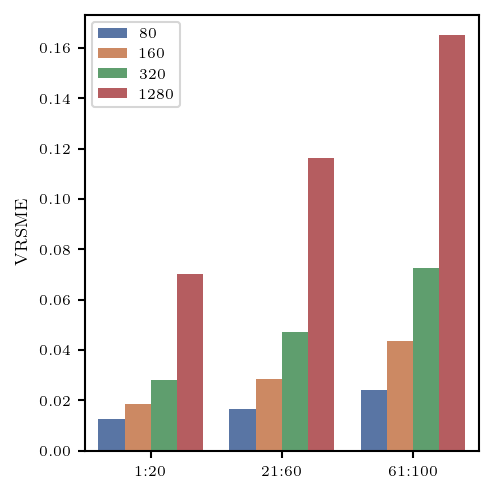

In [4]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(3.2, 3.2))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=weighted_mean,
    errorbar=None,
    palette=sb.color_palette("deep", 4),
)

ax.get_legend().set_title(None)

ax.set_xlabel(None)
ax.set_ylabel("VRSME")

fig.tight_layout(pad=0.33)

plt.savefig(outdir / "euler_ae.pdf", dpi=300, transparent=True)

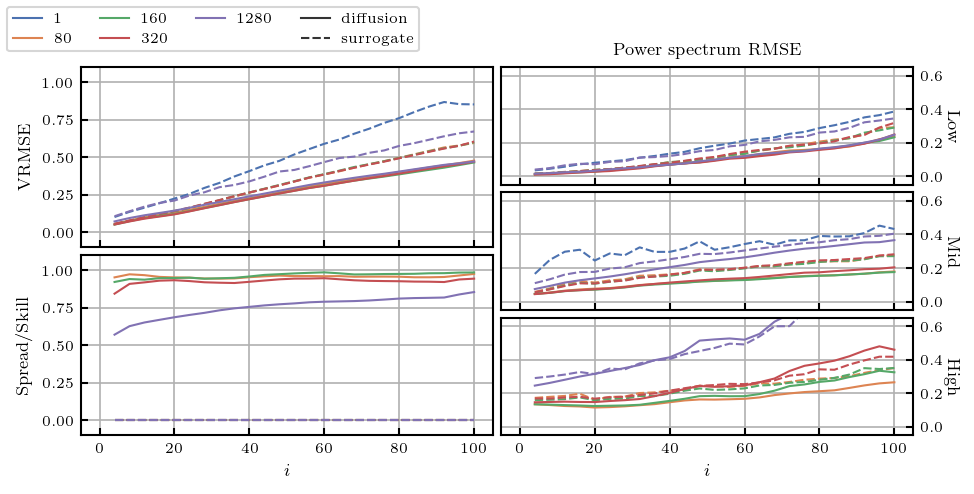

In [5]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "spread_skill"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=weighted_mean,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("$i$")
    ax.set_xlim(-5, 105)
    ax.set_ylim(-0.1, 1.1)

    if metric == "spread_skill":
        ax.set_ylabel("Spread/Skill")
    else:
        ax.set_ylabel(metric)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=weighted_mean,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("$i$")
    ax.set_xlim(-5, 105)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

handles.insert(-2, blank)
labels.insert(-2, None)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=4)

plt.savefig(outdir / "euler_mosaic.pdf", dpi=300, transparent=True)

## Tables

In [6]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                   1:20  21:60 61:100
method      compression                     
autoencoder 80           0.013  0.017  0.024
            160          0.019  0.029  0.044
            320          0.028  0.047  0.072
            1280         0.070  0.116  0.165
diffusion   80           0.087  0.213  0.391
            160          0.081  0.205  0.378
            320          0.080  0.204  0.381
            1280         0.102  0.225  0.396
surrogate   1            0.148  0.378  0.735
            80           0.087  0.243  0.482
            160          0.087  0.246  0.482
            320          0.089  0.245  0.480
            1280         0.152  0.324  0.560

In [7]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon             1:20  21:60 61:100
method    context                     
diffusion 1        0.095  0.213  0.394
          2        0.083  0.209  0.384
          3        0.083  0.212  0.380
surrogate 1        0.114  0.272  0.513
          2        0.098  0.257  0.491
          3        0.098  0.265  0.497

In [8]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                       1:20  21:60 61:100       1:20  21:60 61:100   
method      compression                                                     
autoencoder 80               0.002  0.001  0.001      0.007  0.009  0.014   
            160              0.002  0.002  0.002      0.014  0.024  0.043   
            320              0.003  0.003  0.005      0.025  0.051  0.096   
            1280             0.010  0.018  0.026      0.090  0.179  0.291   
diffusion   80               0.021  0.065  0.162      0.059  0.103  0.152   
            160              0.018  0.063  0.159      0.057  0.100  0.150   
            320              0.016  0.061  0.156      0.056  0.105  0.170   
            1280             0.022  0.066  0.163      0.101  0.194  0.314   
surrogate   1                0.052  0.129  0.279      0.252  0.301  0.377   
            80               0.024  0.074  0.200      0.090  0.156  0.230   
            160              0.023  0.076  0.197      0.082  0.149  0.230   
            320              0.022  0.077  0.200      0.081  0.152  0.237   
            1280             0.057  0.118  0.253      0.144  0.239  0.349   

                        rmse_p_high                
horizon                        1:20  21:60 61:100  
method      compression                            
autoencoder 80                0.086  0.094  0.153  
            160               0.107  0.130  0.235  
            320               0.133  0.180  0.351  
            1280              0.260  0.421  0.785  
diffusion   80                0.127  0.139  0.209  
            160               0.131  0.150  0.254  
            320               0.148  0.192  0.357  
            1280              0.271  0.411  0.723  
surrogate   1                 0.855  1.261  3.425  
            80                0.182  0.206  0.283  
            160               0.165  0.192  0.281  
            320               0.172  0.207  0.325  
            1280              0.306  0.397  0.655

## Images

In [9]:
path = Path("/mnt/ceph/users/frozet/lola/videos/euler_all")

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 1
frames = np.array([5, 15, 25])

for run, method, compression in runs.values:
    files = (path / run).glob("*.npz")
    files = sorted(files)

    for i, file in enumerate(files):
        x, x_hat = np.load(file).values()

        x = x[field, frames, ::2, ::2]
        x_hat = x_hat[:, field, frames, ::2, ::2]

        vmin = np.nanquantile(x, 0.01, keepdims=True) - 1e-2
        vmax = np.nanquantile(x, 0.99, keepdims=True) + 1e-2

        draw(x, vmin=vmin, vmax=vmax, pad=8).save(outdir / f"euler_{i}_gt.png")

        for j in range(len(x_hat)):
            draw(x_hat[j], vmin=vmin, vmax=vmax, pad=8).save(outdir / f"euler_{i}_{method}_{compression:04d}_{j}.png")

In [10]:
path = Path("/mnt/ceph/users/frozet/lola/videos/euler_all")

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 1
frames = np.array([5, 15, 25])

for i in range(7):
    for compression in runs["compression"].unique():
        fig, axs = plt.subplots(1, len(frames), figsize=(3 * 1.2, 1.6), sharex=True, sharey=True)

        for j, (run, _, _) in enumerate(runs[runs["compression"] == compression].values):
            files = (path / run).glob("*.npz")
            files = sorted(files)
            file = files[i]

            x, y = np.load(file).values()

            x = x[field, frames]
            y = y[:, field, frames]

            p_x, k = isotropic_power_spectrum(x, spatial=2)
            p_y, _ = isotropic_power_spectrum(y, spatial=2)
            p_y = p_y.mean(dim=0)

            for ii, frame in enumerate(frames):
                if j == 0:
                    axs[ii].axvline(2, color="red", linestyle="dashed")
                    axs[ii].loglog(1 / k, p_x[ii], base=2, color="black")
                axs[ii].loglog(1 / k, p_y[ii], base=2, color=f"C{j}")

                axs[ii].grid()
                axs[ii].invert_xaxis()
                axs[ii].set_xlabel("Wavelength")
                axs[ii].set_title(f"$i = {frame}$")
                axs[ii].tick_params(direction="in")

            axs[0].set_ylabel("Power spectrum")

        fig.align_labels()
        fig.tight_layout(pad=0.33)

        plt.savefig(outdir / f"euler_psd_{i}_{compression:04d}.pdf", dpi=300, transparent=True)
        plt.close()